# Object detection
The objective is to locate objects in the image. Our model will predict the coordinates of a box that encloses the object.

In [2]:
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt

In [3]:
mx.__version__

'1.7.0'

In [8]:
gcv.__version__

'0.8.0'

## Download de image
This will save the image in the local path of Jupyter installation:

In [7]:
image_url = 'https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg'
image_file_path = 'dog.jpg'
gcv.utils.download(url=image_url, path=image_file_path)

100%|██████████| 160/160 [00:00<00:00, 1272.93KB/s]


'dog.jpg'

## Load the image


In [11]:
image = mx.image.imread('dog.jpg')
print(f'image type: {type(image)}')
print(f'image shape: {image.shape}')
print(f'image data type: {image.dtype}')
print(f'image, minimum value: {image.min().asscalar()}')
print(f'image, maximum value: {image.max().asscalar()}')

image type: <class 'mxnet.ndarray.ndarray.NDArray'>
image shape: (576, 768, 3)
image data type: <class 'numpy.uint8'>
image, minimum value: 0
image, maximum value: 255


In the **image type** shows that image is loaded as an MXNet ndarray.

In the **image shape** shows we have a data layout in HWC format, i.e. the image has a **H**eight of 576 pixels with a **W**idth of 768 pixels and it's a colored image with three **C**hannels.

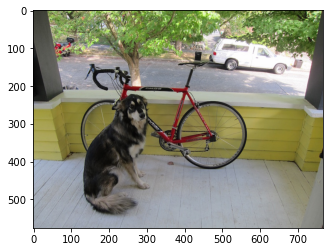

In [12]:
plt.imshow(image.asnumpy())

## Transform image
We need to transform the image to send it to the network or apply the CV model on it. We need to add **N** as a fourth dimension to the HWC format to transform it to NCHW (**N**: batch **C**: channel **H**: hight **W**: width).

In [15]:
transformed_image, chw_image = gcv.data.transforms.presets.yolo.transform_test(
    image, short=512)

print(f'image shape: {transformed_image.shape}')
print(f'image data type: {transformed_image.dtype}')
print(f'image, minimum value: {transformed_image.min().asscalar()}')
print(f'image, maximum value: {transformed_image.max().asscalar()}')

image shape: (1, 3, 512, 683)
image data type: <class 'numpy.float32'>
image, minimum value: -2.1179039478302
image, maximum value: 2.640000104904175


**transformed_image** variable is the image in the new format (NCHW) and the height will be resized to 512 pixels but maintaining the aspect ratio. Furthermore, it's a batch of one image. And it's an array of 32-bit floats instead of 8-bit integers.

**chw_image** variable is a resized version of the image (transformed_image).

## Download and load pre-trained model
We'll use the [**YOLOv3**](https://github.com/ultralytics/yolov3) (You Only Look Once) network, which is the most popular algorithm to object detection, with a [**darknet53**](https://github.com/pjreddie/darknet) backbone that has been trained on the Microsoft's [**COCO**](https://cocodataset.org/) image dataset. Our network parameters are 237 megabytes size and are stored in the mxnet cache, i.e. ~/.mxnet/models/ is the path where we can find the downloaded models.

In [14]:
network = gcv.model_zoo.get_model('yolo3_darknet53_coco', pretrained=True)

100%|██████████| 224190/224190 [02:06<00:00, 1768.93KB/s]


## Make a prediction
Run forward pass to obtain the predicted score for each class

In [31]:
prediction = network(transformed_image)
print(f'Type Prediction object: {type(prediction)}')

Type Prediction object: <class 'tuple'>


In [32]:
for index, array in enumerate(prediction):
    print(f'#{index + 1} {array.shape}')


#1 (1, 100, 1)
#2 (1, 100, 1)
#3 (1, 100, 4)


- The first array contains the object class indexes, i.e. with a shape of (1, 100, 1), we have 1 image, 100 potential objects (the model can predict up to 100 objects in a single image), and 1 class index per object.
- The second array contains the object class probabilities.
- The third array contains the object bounding box coordinates, i.e. with shape (1, 100, 4), we have 1 image, 100 potential objects, and 4 values for each object to define its bounding box (which delimited the object predicted).

## Remove additionalbatch dimension
Remove additional batch dimension for all of the arrays.

In [33]:
prediction = [array[0] for array in prediction]
class_indicies, probabilities, bounding_boxes = prediction


In [34]:
k = 10
print(class_indicies[:k])


[[16.]
 [ 1.]
 [ 7.]
 [ 2.]
 [13.]
 [ 0.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
<NDArray 10x1 @cpu(0)>


The first detected object has a predicted class with number 16, and we see more objects with classes 1, 7, 2, 13 and 0. After this, we have a number of objects with a class index of -1. Where -1 is a special class index that is used to indicate there is no detected object. We have six detected objects in total, with the remaining 94 potential objects being padded with -1 values.

We can show what refers to class 16, for example:

In [36]:
class_index = 16
print(f'{network.classes[class_index]} => {class_index}')

dog => 16


And how many classes do we have in the network? We have 80 which are the image categories that can find in the [COCO dataset](https://cocodataset.org/#detection-eval).

In [37]:
len(network.classes)

80

## Object probabilities
Now, we have the associated object class probability. We can interpret this as our confidence that the class index (image category) is correct.

In [39]:
print(probabilities[:k])


[[ 0.9919528 ]
 [ 0.9600399 ]
 [ 0.62269694]
 [ 0.29241997]
 [ 0.01795173]
 [ 0.01141722]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]]
<NDArray 10x1 @cpu(0)>


If we use a confidence of 50%, then we can say that the first three objects were detected. The -1 values means that there is not confidence in that classes (image categories).

## Object boundings
Now, we have the coordinates of the bounding boxes for each object detected. They specify the coordinates for the top-left corner, and the bottom-right corner.

In [40]:
print(bounding_boxes[:k])


[[116.53647  201.33235  281.90323  482.09094 ]
 [ 93.92975  107.73944  504.75128  375.75415 ]
 [416.78833   69.800644 615.01794  148.89009 ]
 [416.78833   69.800644 615.01794  148.89009 ]
 [ 90.88356  125.878815 504.4449   402.7955  ]
 [532.78235   91.84185  547.3104   104.69111 ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]
 [ -1.        -1.        -1.        -1.      ]]
<NDArray 10x4 @cpu(0)>


## Visualize prediction
Now, wen can graph the result using the resized image above.

<AxesSubplot:>

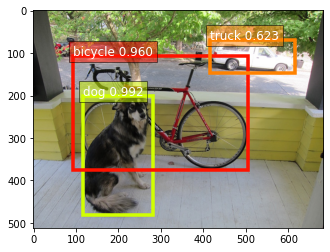

In [42]:
gcv.utils.viz.plot_bbox(chw_image, bounding_boxes,
                        probabilities, class_indicies, class_names=network.classes)

We can see that our network has done a good job of detecting the objects. We have detected a dog, a bike and a truck. Our network missed the tree in the background. But that's because we're using a model that's been pretrained on COCO. And [COCO](https://cocodataset.org/#explore) doesn't have an object class for trees.